In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import gym, action_only
import math

class UpperConfidenceBoundSolver:
    def __init__(self, k = 10, maxT = 1000, explore = 0.0, alpha = 0, confidence_weight = 1):
        self.k = k
        self.maxT = maxT
        self.explore = explore
        self.alpha = alpha
        self.confidence_weight = confidence_weight
        
        self.q = np.random.normal(0,1,self.k)
        self.count = np.zeros(self.k)
        
    def choose_action(self, state, t):
        r = np.random.uniform()
        #print(self.q)
        val = self.q
        logt = math.log(t+1)
        #print(self.count)
        if np.any(self.count > 0):
            val[self.count > 0] += self.confidence_weight * np.sqrt( logt / self.count[self.count>0] )
        if np.any(self.count <= 0):
            val[self.count <= 0] = np.max(val)
        return np.random.randint(0, self.k) if r < self.explore else np.argmax(val)
    
    def update(self, state, action, next_state, reward, done ):
        n = self.count[action]+1
        alpha = self.alpha if self.alpha > 0 else 1.0/n
        self.q[action] += alpha * (reward - self.q[action])
        self.count[action] = n
        
    def run(self):
        env = gym.make('action-only-v0')
        state = env.reset()
        self.rewards = []
        self.actions = []
        for t in range(self.maxT):
            action = self.choose_action(state, t)
            ob, reward, done,_ = env.step(action)
            self.update(state, action, ob, reward, done)
            self.rewards.append(reward)
            best_action = np.argmax(env.qstar)
            self.actions.append( self.count[best_action] / (t+1) * 100 )
            state = ob
            if done:
                break
        #print(agent.q, env.qstar, np.argmax(agent.q), np.argmax(env.qstar))
        return 
           
k = 10
maxT = 1000
explore = 0.1
alpha = 0
ave = {}

for C in [0, 1, 2]:
    ave_tmp = np.zeros(maxT)
    best_tmp = np.zeros(maxT)
    for i in range(2000):
        agent = UpperConfidenceBoundSolver(k, maxT, explore, alpha, C)
        agent.run()
        ave_tmp += 1.0/(i+1)*(agent.rewards-ave_tmp)
        best_tmp += 1.0/(i+1)*(agent.actions-best_tmp)
    ave[C] = (ave_tmp,best_tmp)


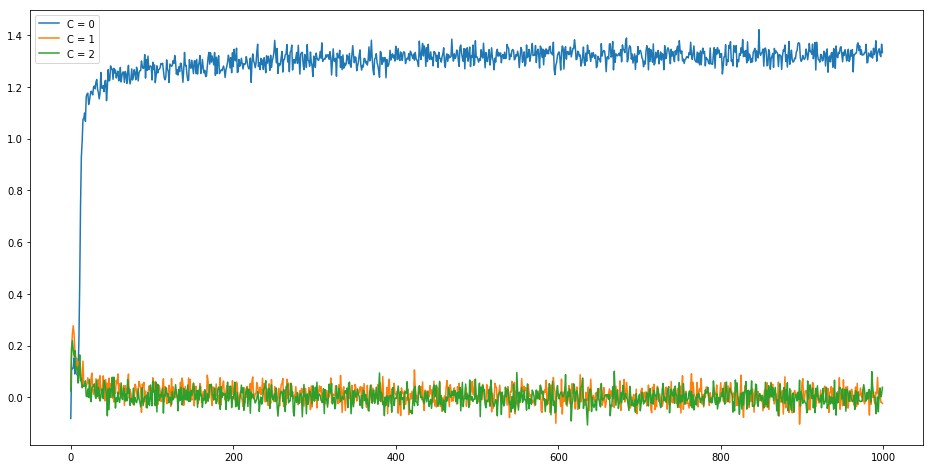

In [22]:
plt.figure(figsize=(16,8))
for e, (a, b) in ave.items():
    plt.plot(a, label="C = " + str(e))
plt.legend()
plt.show()

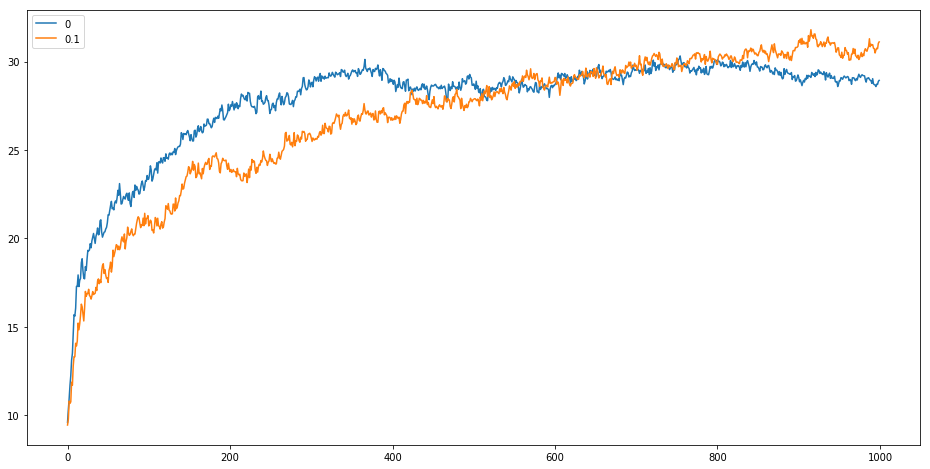

In [4]:
plt.figure(figsize=(16,8))
for e, (a, b) in ave.items():
    plt.plot(b, label=str(e))
plt.legend()
plt.show()